<a href="https://colab.research.google.com/github/ashleyallaico/SkinCancerAI/blob/main/AIFinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [4]:
# Load Packages
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
import matplotlib.image as mpimg

import torch
import torch.nn as nn
import albumentations as A
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from transformers import SamModel, SamProcessor

In [5]:
# Load Dataset
def get_image_paths(base_path):
  class_images = {'benign': [], 'malignant': []}
  for class_name in class_images:
    class_path = os.path.join(base_path, class_name)
    images = sorted(glob(os.path.join(class_path, '*.jpg')))[:10]
    print(f"{class_name.capitalize()} images in {base_path}: {len(images)}")
    class_images[class_name] = images
  return class_images

train_images = get_image_paths('/content/drive/MyDrive/AIProject/data/train')
test_images = get_image_paths('/content/drive/MyDrive/AIProject/data/test')

print(f"Total train images: {len(train_images['benign']) + len(train_images['malignant'])}")
print(f"Total test images: {len(test_images['benign']) + len(test_images['malignant'])}")

Benign images in /content/drive/MyDrive/AIProject/data/train: 10
Malignant images in /content/drive/MyDrive/AIProject/data/train: 10
Benign images in /content/drive/MyDrive/AIProject/data/test: 10
Malignant images in /content/drive/MyDrive/AIProject/data/test: 10
Total train images: 20
Total test images: 20


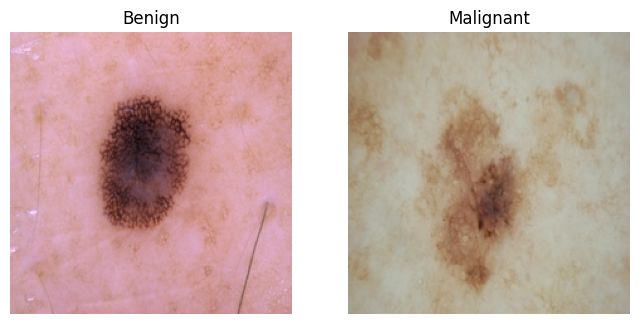

In [6]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(train_images['benign'][0]))
plt.title("Benign")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mpimg.imread(train_images['malignant'][0]))
plt.title("Malignant")
plt.axis("off")

plt.show()

In [7]:
# Load SAM Model and Processor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")
model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [ ]:
#Generate Masks with SAM
def generate_masks(image_paths_dict):
  for class_name, paths in image_paths_dict.items():
    for image_path in paths:
      image = Image.open(image_path).convert("RGB")
      W, H = image.size
      box = [[W//5, H//5, 4*W//5, 4*H//5]]

      inputs = processor(image, input_boxes=[box], return_tensors="pt").to(model.device)

      with torch.no_grad():
        outputs = model(**inputs)

        masks = processor.post_process_masks(
          outputs.pred_masks,
          inputs["original_sizes"],
          inputs["reshaped_input_sizes"]
        )

        predicted_mask = masks[0][0][0].cpu().numpy()

        mask_path = image_path.replace('.jpg', '_masks.png')
        Image.fromarray((predicted_mask * 255).astype(np.uint8)).save(mask_path)

generate_masks(train_images)
generate_masks(test_images)

In [9]:
# Custom Dataset & Preprocessing
class SkinCancerSegmentationDataset(Dataset):
  def __init__(self, image_paths, transform=None):
    self.image_paths = image_paths
    self.transform = transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    image_path = self.image_paths[idx]
    mask_path = image_path.replace('.jpg', '_masks.png')

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = mask.astype(np.uint8)
    mask = np.expand_dims(mask, axis=-1)

    if self.transform:
      augmented = self.transform(image=image, mask=mask)
      image = augmented["image"]
      mask = augmented["mask"]

    return image, mask

In [10]:
# Define Transformation
train_trainsform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

test_trainsform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

# Create DataLoaders
train_image_paths = train_images['benign'] + train_images['malignant']
test_image_paths = test_images['benign'] + test_images['malignant']

train_dataset = SkinCancerSegmentationDataset(train_image_paths, transform=train_trainsform)
test_dataset = SkinCancerSegmentationDataset(test_image_paths, transform=test_trainsform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [15]:
# Existing Method: U-Net Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1
).to(device)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training
epochs = 15
unet_ious = []
unet_accuracies = []
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()
        masks = masks.permute(0, 3, 1, 2) / 255.0

        preds = model(images)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_loss /= len(train_loader)

    # Model Evaluation
    model.eval()
    iou_total = 0
    total_accuracy = 0

    with torch.no_grad():
        for images, masks in test_loader:
          images = images.to(device)
          masks = masks.to(device).float()
          masks = masks.permute(0, 3, 1, 2) / 255.0

          preds = torch.sigmoid(model(images))
          binary_preds = (preds > 0.5).float()

          intersection = (binary_preds.bool() & masks.bool()).float().sum((1, 2, 3))
          union = (binary_preds.bool() + masks.bool()).float().sum((1, 2, 3))
          iou = (intersection + 1e-6) / (union + 1e-6)
          iou_total += iou.mean().item()

          correct = (binary_preds == masks).float().sum()
          total = torch.numel(binary_preds)
          accuracy = correct / total
          total_accuracy += accuracy.item()

    avg_iou = iou_total / len(test_loader)
    avg_acc = total_accuracy / len(test_loader)

    unet_ious.append(avg_iou)
    unet_accuracies.append(avg_acc)

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Test IoU: {avg_iou:.4f} | Test Accuracy: {avg_acc:.4f}")

Epoch 1/15 | Train Loss: 0.1907 | Test IoU: 0.3173 | Test Accuracy: 0.3404
Epoch 2/15 | Train Loss: 0.1514 | Test IoU: 0.3558 | Test Accuracy: 0.4432
Epoch 3/15 | Train Loss: 0.1418 | Test IoU: 0.4383 | Test Accuracy: 0.6090
Epoch 4/15 | Train Loss: 0.1362 | Test IoU: 0.5276 | Test Accuracy: 0.7399
Epoch 5/15 | Train Loss: 0.1268 | Test IoU: 0.5857 | Test Accuracy: 0.8041
Epoch 6/15 | Train Loss: 0.1224 | Test IoU: 0.6234 | Test Accuracy: 0.8392
Epoch 7/15 | Train Loss: 0.1209 | Test IoU: 0.6405 | Test Accuracy: 0.8525
Epoch 8/15 | Train Loss: 0.1108 | Test IoU: 0.6433 | Test Accuracy: 0.8509
Epoch 9/15 | Train Loss: 0.1175 | Test IoU: 0.6641 | Test Accuracy: 0.8644
Epoch 10/15 | Train Loss: 0.1119 | Test IoU: 0.6769 | Test Accuracy: 0.8722
Epoch 11/15 | Train Loss: 0.1014 | Test IoU: 0.6815 | Test Accuracy: 0.8781
Epoch 12/15 | Train Loss: 0.0973 | Test IoU: 0.6648 | Test Accuracy: 0.8738
Epoch 13/15 | Train Loss: 0.0975 | Test IoU: 0.6763 | Test Accuracy: 0.8788
Epoch 14/15 | Train L

In [16]:
class AttentionBlock(nn.Module):
  def __init__(self, F_g, F_l, F_int):
    super(AttentionBlock, self).__init__()
    self.W_g = nn.Sequential(
    nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
    nn.BatchNorm2d(F_int)
    )
    self.W_x = nn.Sequential(
    nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
    nn.BatchNorm2d(F_int)
    )
    self.psi = nn.Sequential(
    nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
    nn.BatchNorm2d(1),
    nn.Sigmoid()
    )
    self.relu = nn.ReLU(inplace=True)

  def forward(self, g, x):
    g1 = self.W_g(g)
    x1 = self.W_x(x)
    psi = self.relu(g1 + x1)
    psi = self.psi(psi)
    return x * psi

class AttentionUNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
    super(AttentionUNet, self).__init__()
    self.encoder = nn.ModuleList()
    self.pool = nn.MaxPool2d(2)

    current_channels = in_channels
    for feature in features:
      self.encoder.append(self._conv_block(current_channels, feature))
      current_channels = feature

    self.bottleneck = self._conv_block(features[-1], features[-1]*2)

    self.upconvs = nn.ModuleList()
    self.attentions = nn.ModuleList()
    self.decoder = nn.ModuleList()

    for feature in reversed(features):
      self.upconvs.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
      self.attentions.append(AttentionBlock(F_g=feature, F_l=feature, F_int=feature//2))
      self.decoder.append(self._conv_block(feature*2, feature))

    self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

  def forward(self, x):
    enc_features = []
    for encode in self.encoder:
        x = encode(x)
        enc_features.append(x)
        x = self.pool(x)

    x = self.bottleneck(x)

    for idx in range(len(self.upconvs)):
        x = self.upconvs[idx](x)
        att = self.attentions[idx](x, enc_features[-(idx+1)])
        x = torch.cat((att, x), dim=1)
        x = self.decoder[idx](x)

    return self.final_conv(x)

  def _conv_block(self, in_ch, out_ch):
    return nn.Sequential(
    nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_ch),
    nn.ReLU(inplace=True),
    nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
    nn.BatchNorm2d(out_ch),
    nn.ReLU(inplace=True)
    )

In [17]:
# Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AttentionUNet(in_channels=3, out_channels=1).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.BCEWithLogitsLoss()

epochs = 15
att_unet_ious = []
att_unet_accuracies = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device).float()
        masks = masks.permute(0, 3, 1, 2) / 255.0

        preds = model(images)
        loss = loss_fn(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    #Evaluate Model
    model.eval()
    iou_total = 0
    total_accuracy = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device).float()
            masks = masks.permute(0, 3, 1, 2) / 255.0

            preds = torch.sigmoid(model(images))
            binary_preds = (preds > 0.5).float()

            intersection = (binary_preds.bool() & masks.bool()).float().sum((1, 2, 3))
            union = (binary_preds.bool() + masks.bool()).float().sum((1, 2, 3))
            iou = (intersection + 1e-6) / (union + 1e-6)
            iou_total += iou.mean().item()

            correct = (binary_preds == masks).float().sum()
            total = torch.numel(binary_preds)
            accuracy = correct / total
            total_accuracy += accuracy.item()

    avg_iou = iou_total / len(test_loader)
    avg_acc = total_accuracy / len(test_loader)

    att_unet_ious.append(avg_iou)
    att_unet_accuracies.append(avg_acc)

    print(f"Epoch {epoch+1}/{epochs} | Loss: {train_loss:.4f} | IoU: {avg_iou:.4f} | Accuracy: {avg_acc:.4f}")

Epoch 1/15 | Loss: 0.6764 | IoU: 0.3175 | Accuracy: 0.4472
Epoch 2/15 | Loss: 0.5831 | IoU: 0.3135 | Accuracy: 0.3303
Epoch 3/15 | Loss: 0.5353 | IoU: 0.3133 | Accuracy: 0.3308
Epoch 4/15 | Loss: 0.4887 | IoU: 0.3399 | Accuracy: 0.4188
Epoch 5/15 | Loss: 0.4557 | IoU: 0.5650 | Accuracy: 0.7795
Epoch 6/15 | Loss: 0.4476 | IoU: 0.5789 | Accuracy: 0.7664
Epoch 7/15 | Loss: 0.3809 | IoU: 0.6409 | Accuracy: 0.8315
Epoch 8/15 | Loss: 0.3783 | IoU: 0.6812 | Accuracy: 0.8568
Epoch 9/15 | Loss: 0.3523 | IoU: 0.6727 | Accuracy: 0.8511
Epoch 10/15 | Loss: 0.3489 | IoU: 0.7038 | Accuracy: 0.8722
Epoch 11/15 | Loss: 0.3213 | IoU: 0.6969 | Accuracy: 0.8699
Epoch 12/15 | Loss: 0.3002 | IoU: 0.7288 | Accuracy: 0.8902
Epoch 13/15 | Loss: 0.3180 | IoU: 0.7379 | Accuracy: 0.8953
Epoch 14/15 | Loss: 0.3095 | IoU: 0.7279 | Accuracy: 0.8883
Epoch 15/15 | Loss: 0.2926 | IoU: 0.7265 | Accuracy: 0.8838


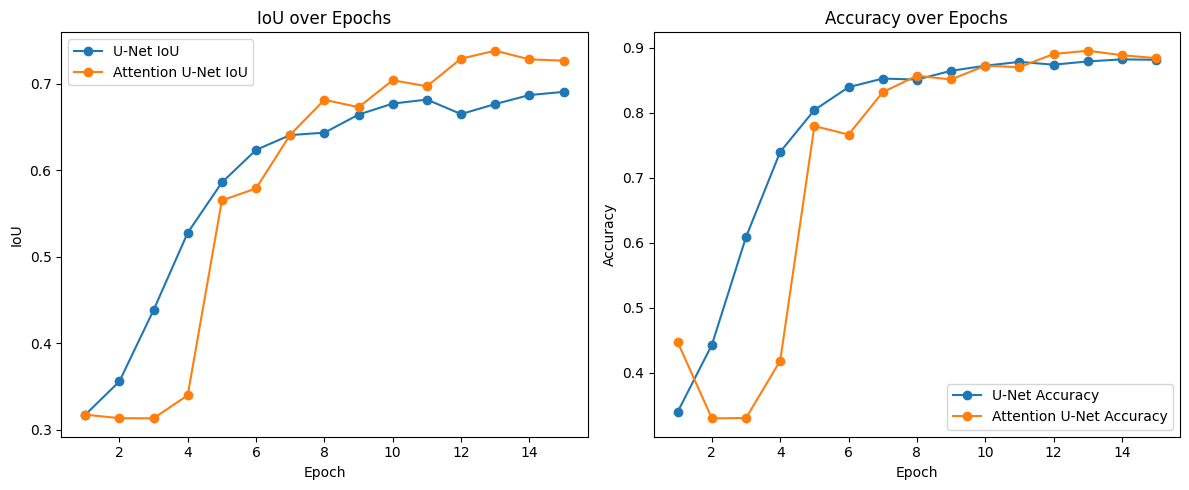

In [18]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))

# Plot IoU
plt.subplot(1, 2, 1)
plt.plot(epochs_range, unet_ious, label="U-Net IoU", marker='o')
plt.plot(epochs_range, att_unet_ious, label="Attention U-Net IoU", marker='o')
plt.xlabel("Epoch")
plt.ylabel("IoU")
plt.title("IoU over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, unet_accuracies, label="U-Net Accuracy", marker='o')
plt.plot(epochs_range, att_unet_accuracies, label="Attention U-Net Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.legend()

plt.tight_layout()
plt.show()